In [ ]:
# endpoint
# https://api.twitter.com/1.1/tweets/search/30day/env1.json

## Fetch data

In [3]:
from searchtweets import ResultStream, gen_rule_payload, load_credentials

In [4]:
premium_search_args = load_credentials("twitter_keys.yaml",
                                       yaml_key="search_tweets_30_day",
                                       env_overwrite=False)

Grabbing bearer token from OAUTH


In [5]:
premium_search_args

{'bearer_token': 'AAAAAAAAAAAAAAAAAAAAAPjB8gAAAAAAv0R2m1GfEoGFV8WmOjYMsN1J%2B7Y%3Df2NGIlc0BMuYCPdmCw3MKDE2jto6BQTFsDBTG0h4s644kKRpjq',
 'endpoint': 'https://api.twitter.com/1.1/tweets/search/30day/env1.json'}

In [84]:
#'RozeckaPL,GoTracz,martalempart,MichalakJerzy,KatarzynaObara,SutrykJacek'
rule = gen_rule_payload('from:SutrykJacek', results_per_call=100)

print(rule)

{"query": "from:SutrykJacek", "maxResults": 100}


In [85]:
rs = ResultStream(rule_payload=rule,
                  max_results=1000,
                  max_pages=1,
                  **premium_search_args)

print(rs)

ResultStream: 
	{
    "username": null,
    "endpoint": "https://api.twitter.com/1.1/tweets/search/30day/env1.json",
    "rule_payload": {
        "query": "from:SutrykJacek",
        "maxResults": 100
    },
    "tweetify": true,
    "max_results": 1000
}


In [86]:
tweets = list(rs.stream())

In [87]:
len(tweets)

207

## Save data to file

In [88]:
file = 'SutrykJacek.txt'

with open(file, 'w') as f:
    for tweet in tweets:
        json.dump(tweet, f)
        f.write('\n')

## Read data from file

In [5]:
def read_tweets(file_name):
    data = []
    file = open(file_name, 'r') 
    for line in file:
        try:
            tweet = json.loads(line)
            data.append(tweet)
        except:
            continue
    return data

#  Analysis & Visualization

In [199]:
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import datetime

In [10]:
def get_date_range():
    numdays=31
    base = datetime.date.today()
    return [base - datetime.timedelta(days=x) for x in range(0, numdays)]

In [11]:
def get_missing_data(dates_present):
    all_dates = get_date_range()
    
    dates_absent = []
    for d in all_dates:
        if d not in dates_present:
            dates_absent.append(d)

    return pd.Series([0]*len(dates_absent), index=dates_absent)

## Show the number of tweets in time for candidates 

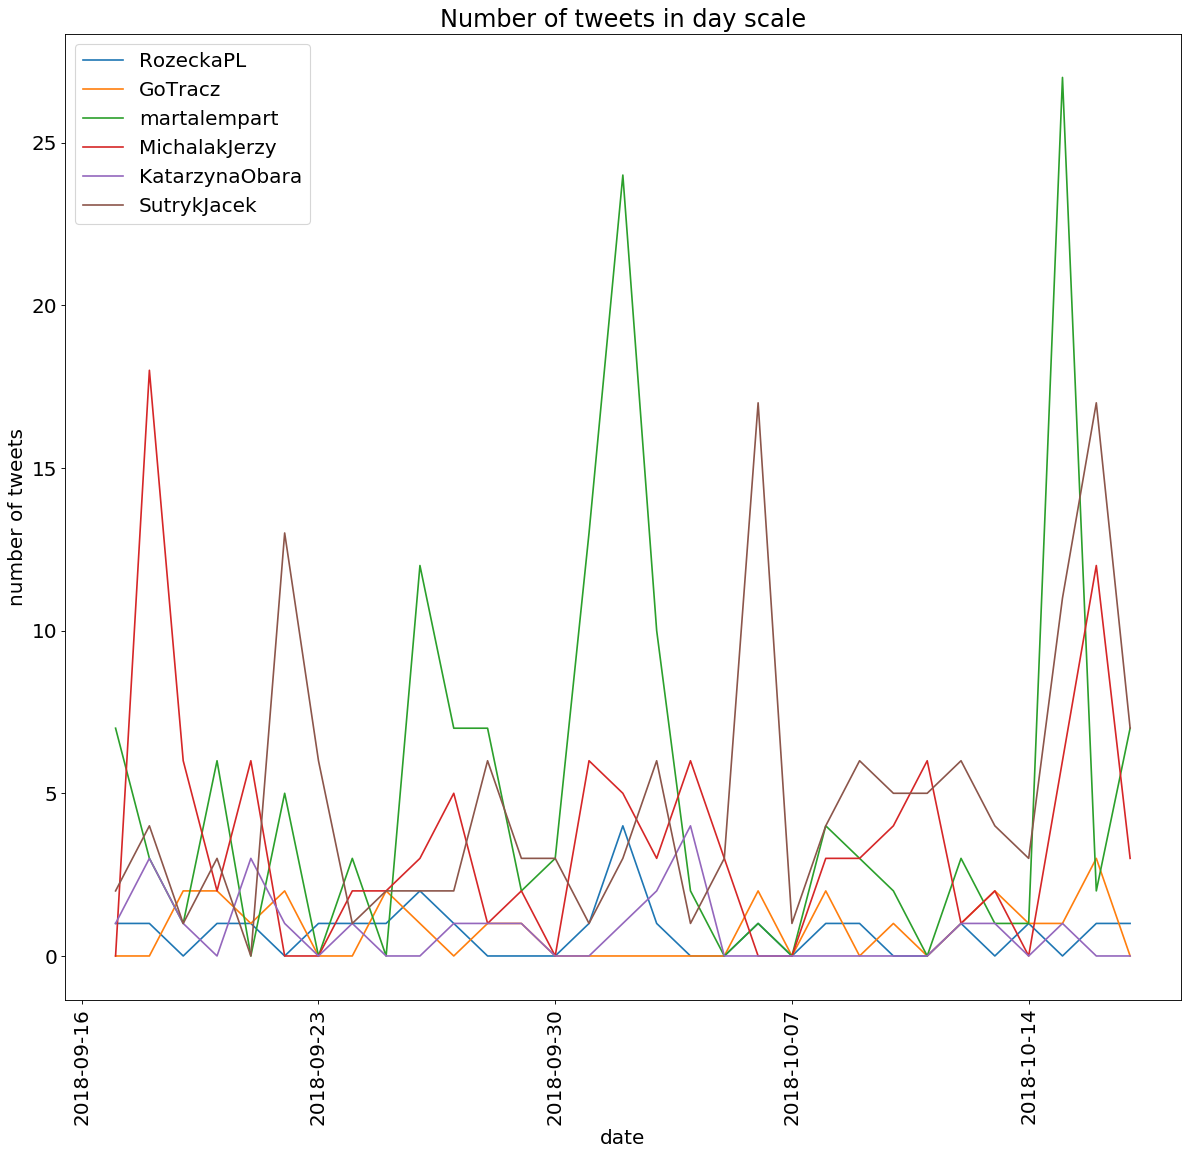

In [305]:
matplotlib.rcParams.update({'font.size': 18})

candidates = ['RozeckaPL','GoTracz','martalempart','MichalakJerzy','KatarzynaObara','SutrykJacek']

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.title('Number of tweets in day scale')
plt.ylabel('number of tweets')
plt.xlabel('date')
plt.xticks(rotation=90)

for candidate in candidates:
    data_l = read_tweets(candidate + '.txt')
    data_df = convert_list_to_df(data_l)
    
    data_completed = count_originals_tweets_per_day(data_df).append(get_missing_data(count_originals_tweets_per_day(data_df)))
    plt.plot(data_completed.sort_index(), label=candidate)
    
plt.legend()   
plt.show()

## Show the number of re-tweets in time (x axis) 

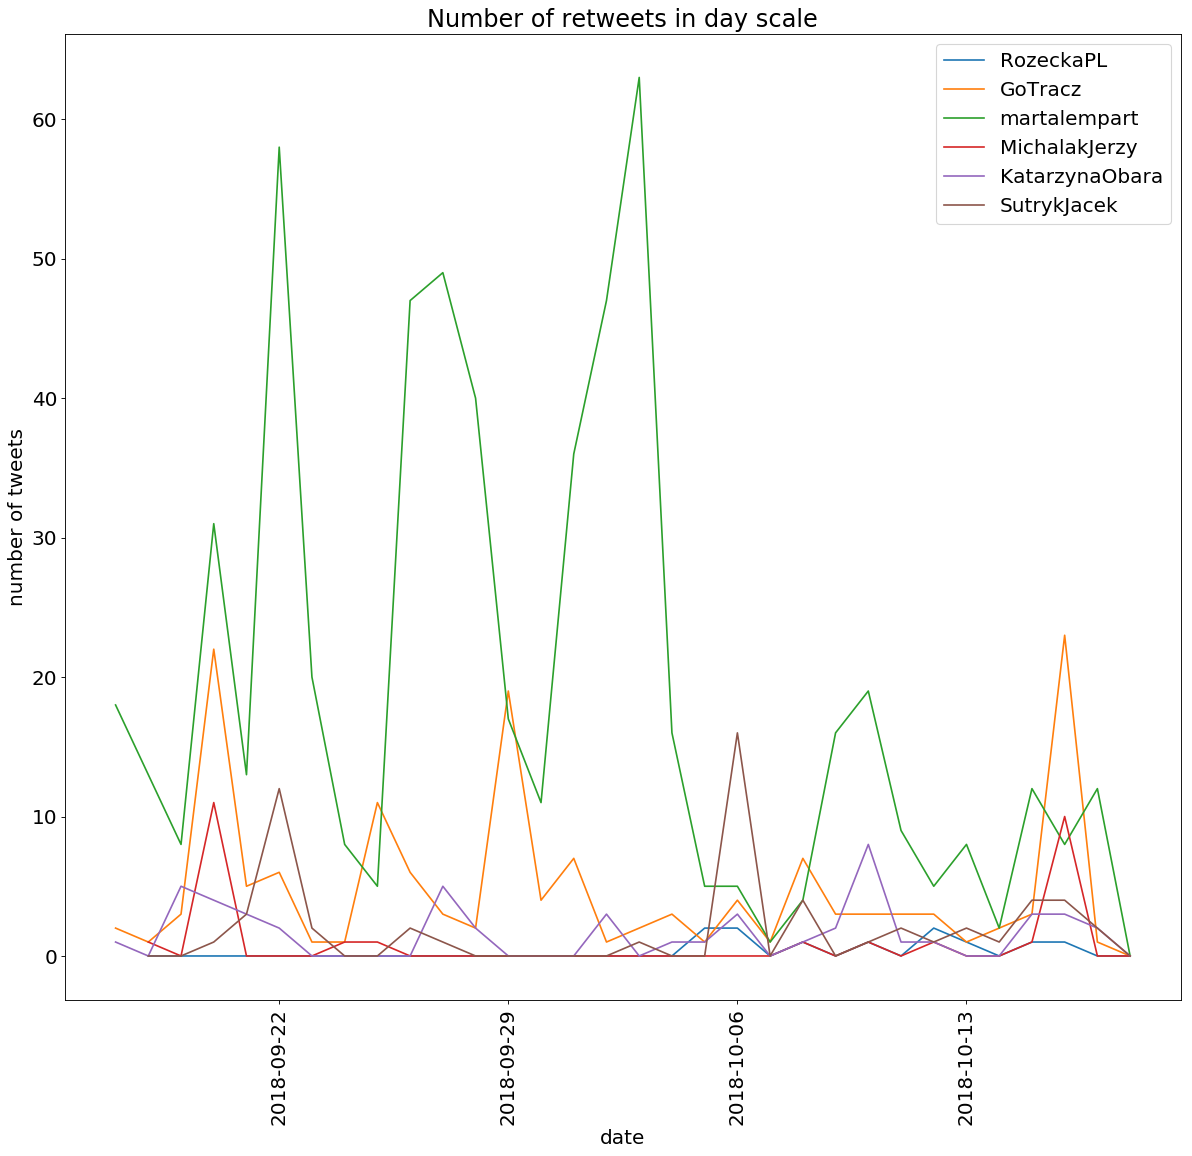

In [39]:
matplotlib.rcParams.update({'font.size': 18})

candidates = ['RozeckaPL','GoTracz','martalempart','MichalakJerzy','KatarzynaObara','SutrykJacek']

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.title('Number of retweets in day scale')
plt.ylabel('number of tweets')
plt.xlabel('date')
plt.xticks(rotation=90)

for candidate in candidates:
    data_l = read_tweets(candidate + '.txt')
    data_df = convert_list_to_df(data_l)
    
    data_completed = count_retweets_per_day(data_df).append(get_missing_data(count_retweets_per_day(data_df)))
    plt.plot(data_completed.sort_index(), label=candidate)
    
plt.legend()   
plt.show()

In [12]:
def map_month(month_name):
    switcher = {
        'Sep': '09',
        'Oct': '10',
    }
    return switcher.get(month_name)

def get_date_time_from_string(text):
    # 'Wed Oct 17 11:17:53 +0000 2018'
    data = text.split()
    time = data[3]
    date= datetime.date(int(data[5]), int(map_month(data[1])), int(data[2]))
    return date, time

In [13]:
def convert_list_to_df(tweets):
    data = {'date': [], 'time': [], 'retweeted': []}
    dates, times, retweeted = [], [], []
    
    for tweet in tweets:
        date, time = get_date_time_from_string(tweet['created_at'])
        dates.append(date)
        times.append(time)
        retweeted.append(False if tweet.get('retweeted_status')==None else True)
        
    data['date'] = dates
    data['time'] = times
    data['retweeted'] = retweeted
    
    return pd.DataFrame.from_dict(data)

In [19]:
def count_originals_tweets_per_day(df):
    return df[df['retweeted']==False].groupby('date').agg('count')['time']

def count_retweets_per_day(df):
    return df[df['retweeted']==True].groupby('date').agg('count')['time']

## Show the popularity of tweets in time (number of likes, number of retweets) - likes assigned to tweet's publication date

In [103]:
def convert_list_to_df2(tweets):
    data = {'date': [], 'time': [], 'retweeted': [], 'retweet_count': [], 'favorite_count': []}
    dates, times, retweeted, retweet_count, favorite_count = [], [], [], [], []
    
    for tweet in tweets:
        date, time = get_date_time_from_string(tweet['created_at'])
        dates.append(date)
        times.append(time)
        if tweet.get('retweeted_status') == None:
            retweeted.append(False)
            retweet_count.append(tweet['retweet_count'])
            favorite_count.append(tweet['favorite_count'])
        else:
            retweeted.append(True)
            retweet_count.append(tweet['retweeted_status']['retweet_count'])
            favorite_count.append(tweet['retweeted_status']['favorite_count'])
        
    data['date'] = dates
    data['time'] = times
    data['retweeted'] = retweeted
    data['retweet_count'] = retweet_count
    data['favorite_count'] = favorite_count
    
    return pd.DataFrame.from_dict(data)

In [105]:
def count_likes_and_retweets(df):
    return df.groupby('date').sum()

def count_likes_and_retweets_in_usermade_tweets(df):
    return df[df['retweeted'] == False].groupby('date').sum()

## popularity of tweets posted or retweeted by candidate

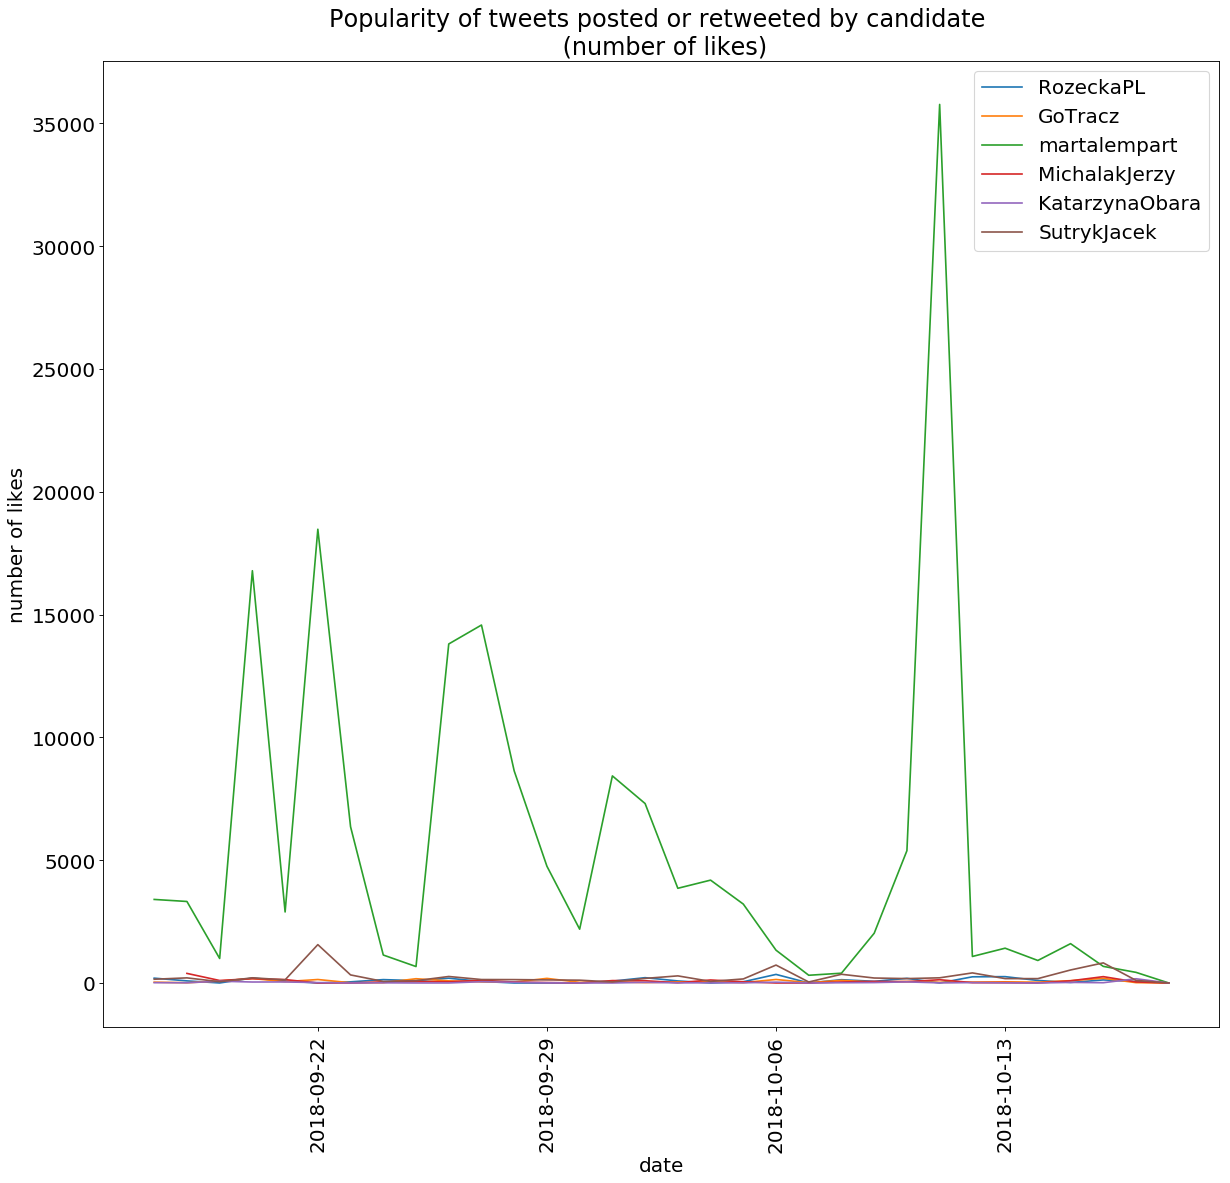

In [107]:
matplotlib.rcParams.update({'font.size': 18})

candidates = ['RozeckaPL','GoTracz','martalempart','MichalakJerzy','KatarzynaObara','SutrykJacek']

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.title('Popularity of tweets posted or retweeted by candidate \n (number of likes)')
plt.ylabel('number of likes')
plt.xlabel('date')
plt.xticks(rotation=90)

for candidate in candidates:
    data_l = read_tweets(candidate + '.txt')
    data_df = convert_list_to_df2(data_l)
    
    counted_s = count_likes_and_retweets(data_df)['favorite_count']
    data_completed = counted_s.append(get_missing_data(counted_s))
    
    plt.plot(data_completed.sort_index(), label=candidate)
    
plt.legend()   
plt.show()

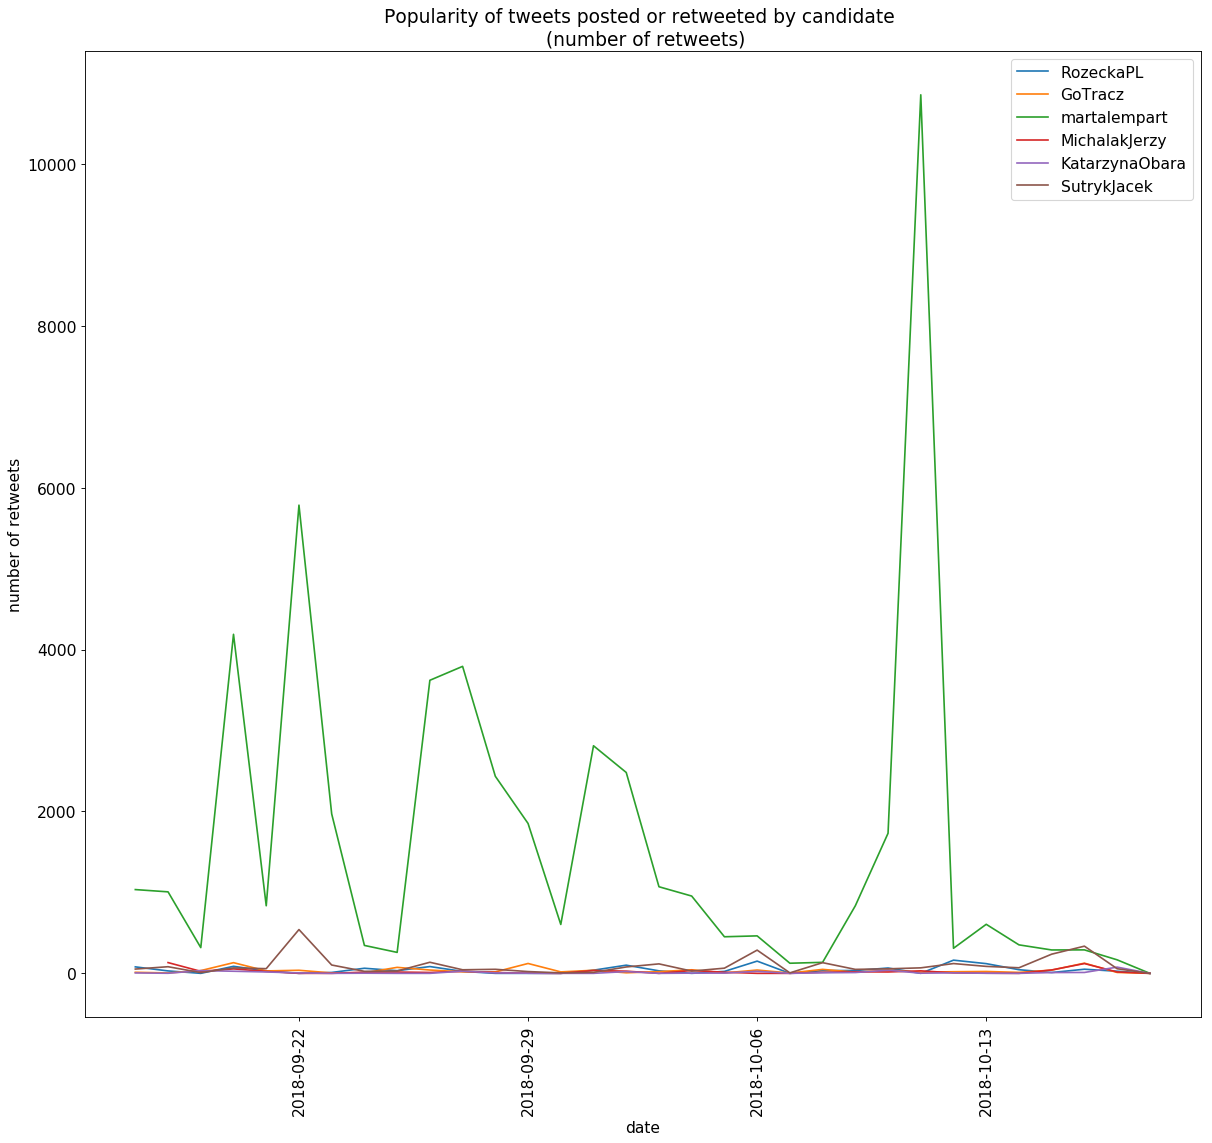

In [108]:
matplotlib.rcParams.update({'font.size': 14})

candidates = ['RozeckaPL','GoTracz','martalempart','MichalakJerzy','KatarzynaObara','SutrykJacek']

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.title('Popularity of tweets posted or retweeted by candidate \n (number of retweets)')
plt.ylabel('number of retweets')
plt.xlabel('date')
plt.xticks(rotation=90)

for candidate in candidates:
    data_l = read_tweets(candidate + '.txt')
    data_df = convert_list_to_df2(data_l)
    
    counted_s = count_likes_and_retweets(data_df)['retweet_count']
    data_completed = counted_s.append(get_missing_data(counted_s))
    
    plt.plot(data_completed.sort_index(), label=candidate)
    
plt.legend()   
plt.show()

## number of likes in tweets posted by candidate (not retweeted) 

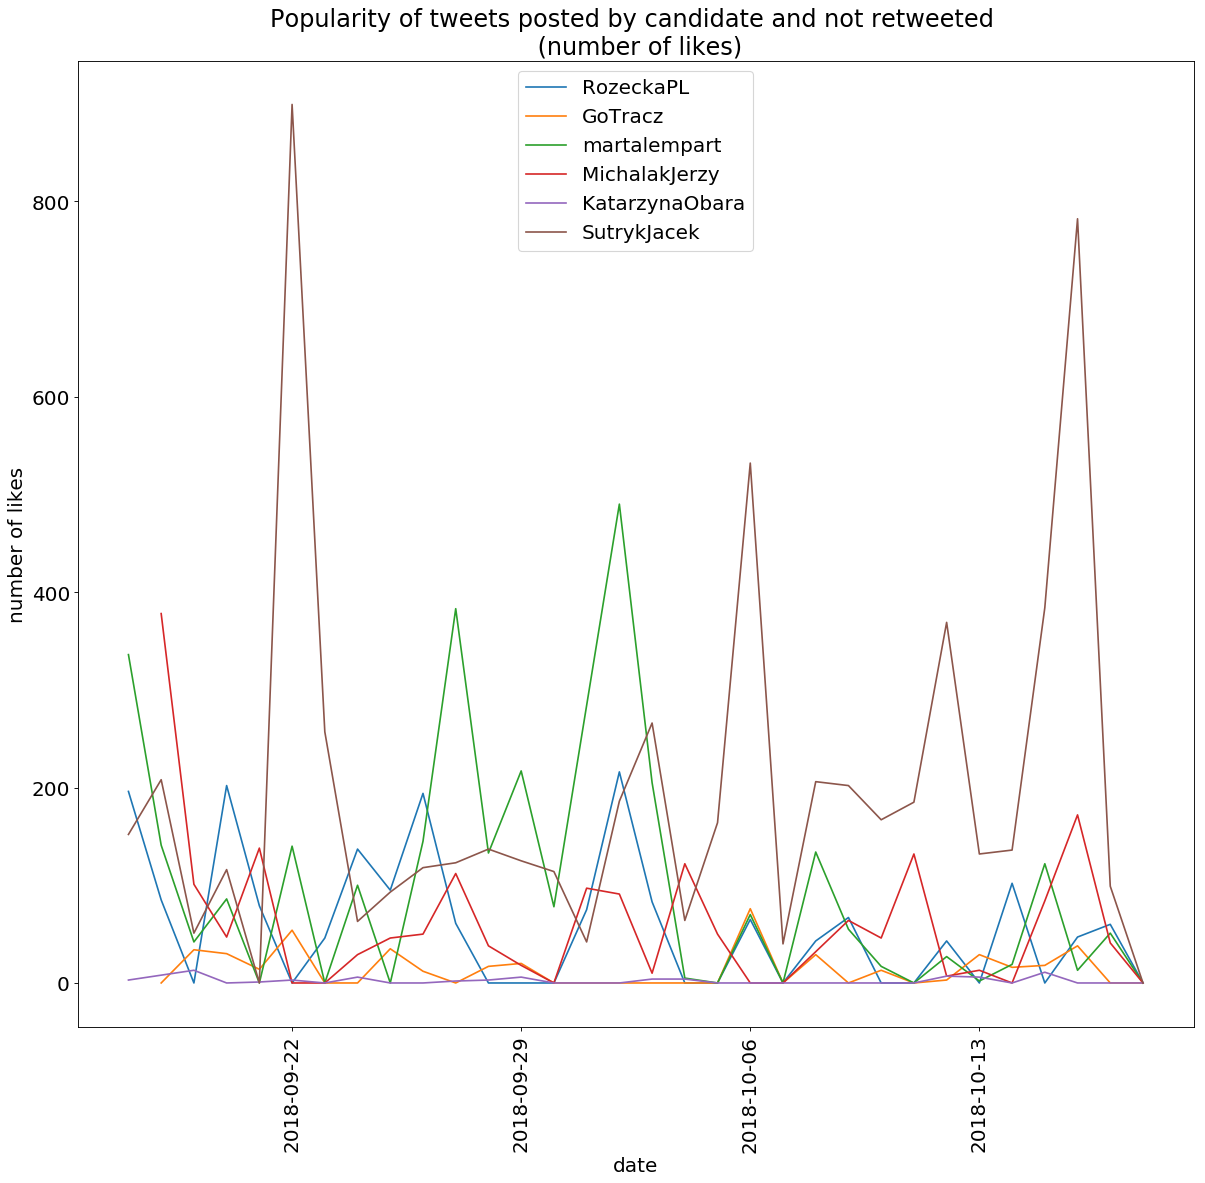

In [109]:
matplotlib.rcParams.update({'font.size': 18})

candidates = ['RozeckaPL','GoTracz','martalempart','MichalakJerzy','KatarzynaObara','SutrykJacek']

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.title('Popularity of tweets posted by candidate and not retweeted \n (number of likes)')
plt.ylabel('number of likes')
plt.xlabel('date')
plt.xticks(rotation=90)

for candidate in candidates:
    data_l = read_tweets(candidate + '.txt')
    data_df = convert_list_to_df2(data_l)
    
    counted_s = count_likes_and_retweets_in_usermade_tweets(data_df)['favorite_count']
    data_completed = counted_s.append(get_missing_data(counted_s))
    
    plt.plot(data_completed.sort_index(), label=candidate)
    
plt.legend()   
plt.show()

## number of retweets in tweets posted by candidate (not retweeted) 

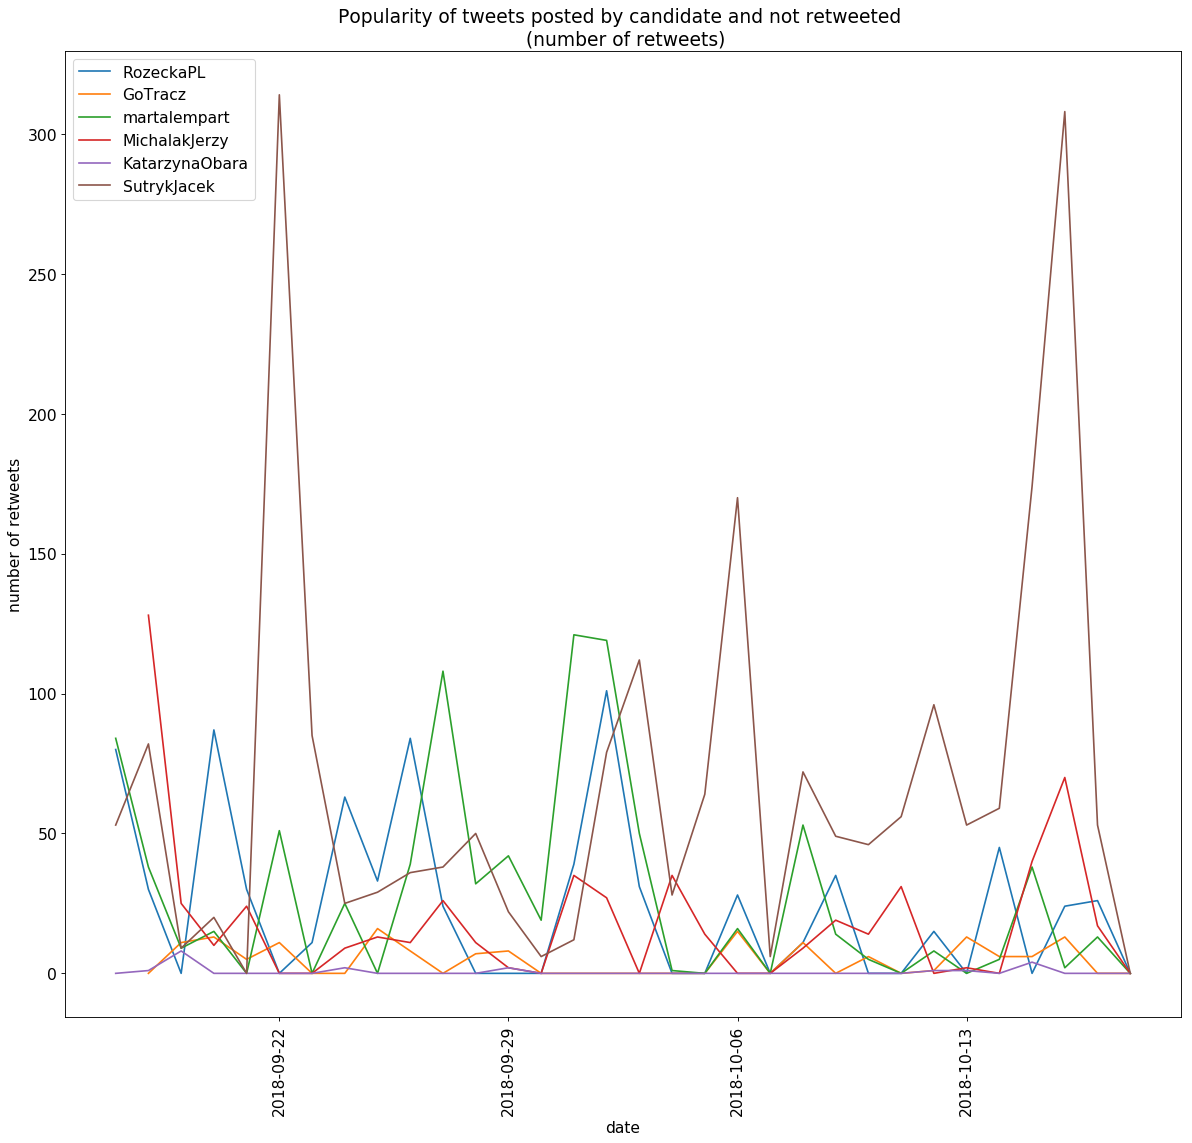

In [110]:
matplotlib.rcParams.update({'font.size': 14})

candidates = ['RozeckaPL','GoTracz','martalempart','MichalakJerzy','KatarzynaObara','SutrykJacek']

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.title('Popularity of tweets posted by candidate and not retweeted \n (number of retweets)')
plt.ylabel('number of retweets')
plt.xlabel('date')
plt.xticks(rotation=90)

for candidate in candidates:
    data_l = read_tweets(candidate + '.txt')
    data_df = convert_list_to_df2(data_l)
    
    counted_s = count_likes_and_retweets_in_usermade_tweets(data_df)['retweet_count']
    data_completed = counted_s.append(get_missing_data(counted_s))
    
    plt.plot(data_completed.sort_index(), label=candidate)
    
plt.legend()   
plt.show()

# Show the distribution of activity in the scope of a day (on an hourly basis) and week (on a daily basis) for tweeting and retweeting activities (both)

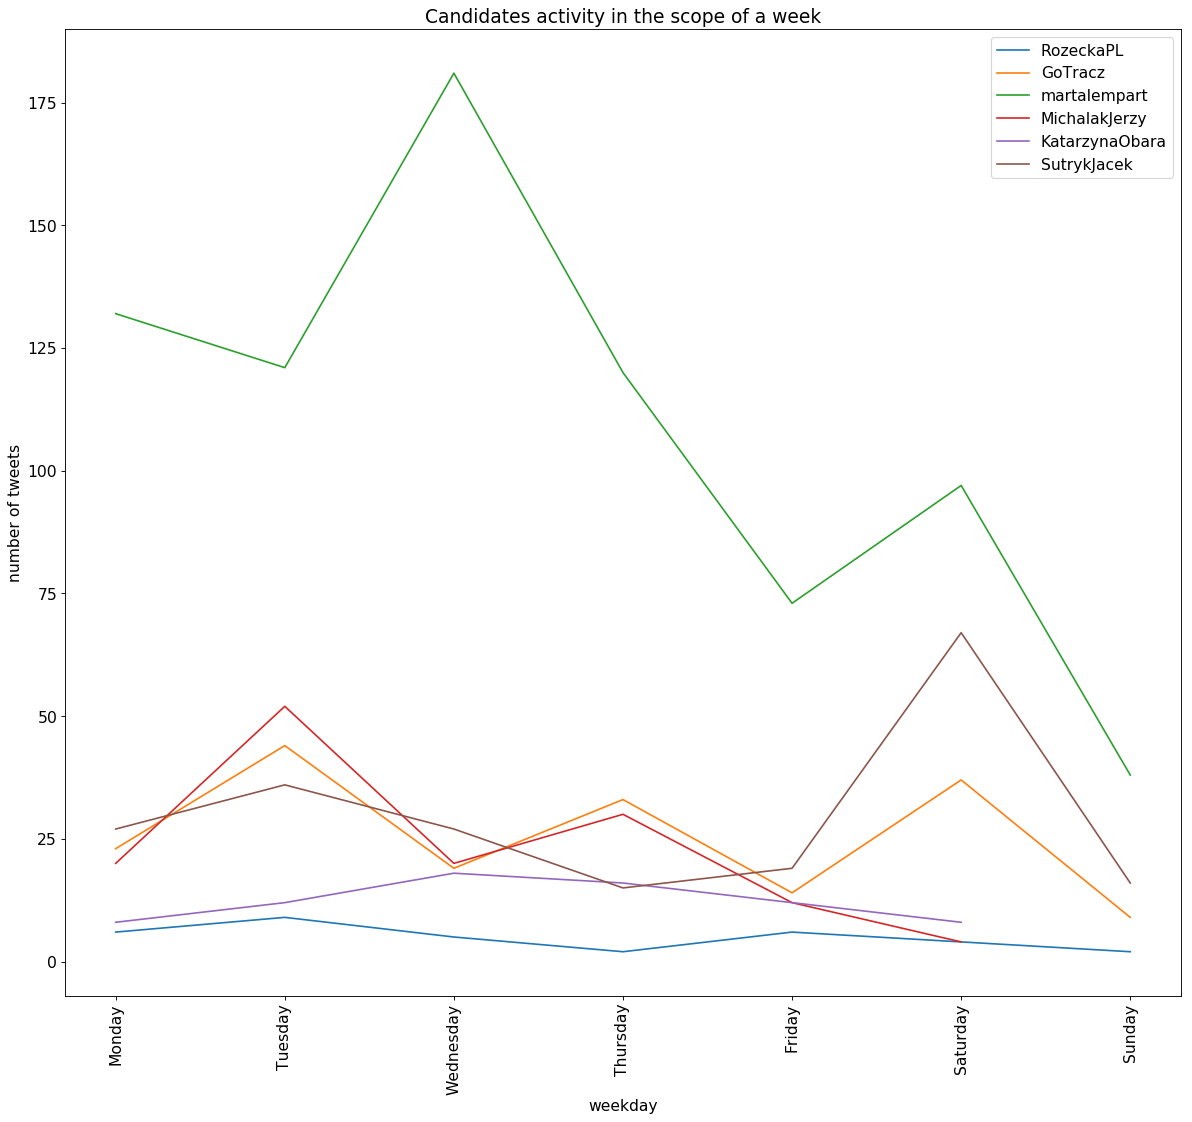

In [101]:
matplotlib.rcParams.update({'font.size': 14})

candidates = ['RozeckaPL','GoTracz','martalempart','MichalakJerzy','KatarzynaObara','SutrykJacek']

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.title('Candidates activity in the scope of a week')
plt.ylabel('number of tweets')
plt.xlabel('weekday')
plt.xticks(rotation=90)

for candidate in candidates:
    data_l = read_tweets(candidate + '.txt')
    data_df = convert_list_to_df(data_l)
    
    data_df['weekday'] = data_df['date'].apply(lambda x: x.weekday())
    data_completed = data_df.groupby('weekday').agg('count')['date']
        
    plt.plot(data_completed, label=candidate)

x = np.arange(0,7)
my_xticks = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.xticks(x, my_xticks)    
plt.legend()   
plt.show()

In [82]:
def get_nearest_hour(time):
    # time is a string
    return int(time[0:2]) + ( 1 if int(time[3:5]) >= 30 else 0 )

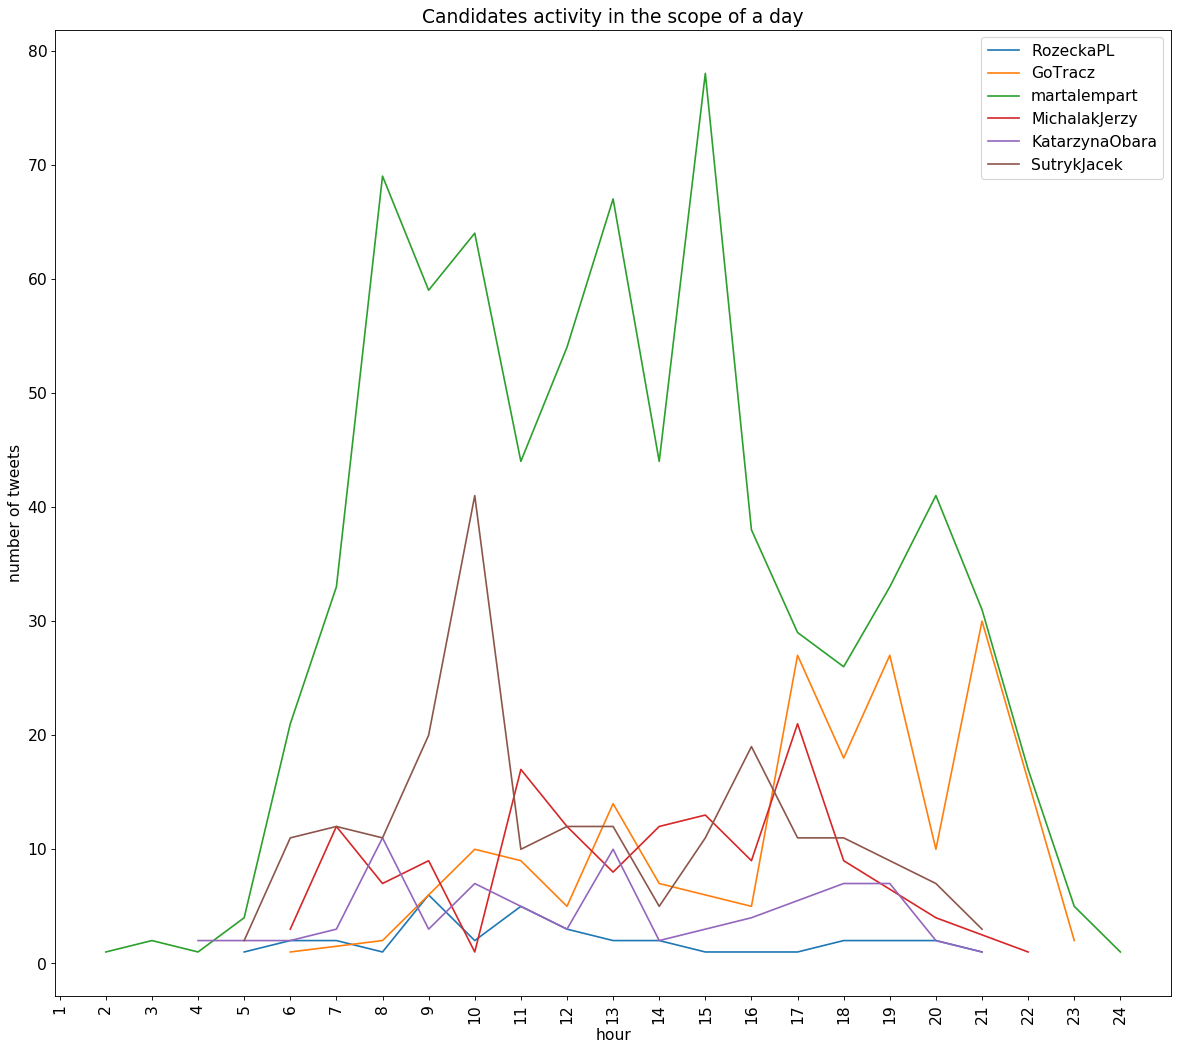

In [98]:
matplotlib.rcParams.update({'font.size': 14})

candidates = ['RozeckaPL','GoTracz','martalempart','MichalakJerzy','KatarzynaObara','SutrykJacek']

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.title('Candidates activity in the scope of a day')
plt.ylabel('number of tweets')
plt.xlabel('hour')
plt.xticks(rotation=90)

for candidate in candidates:
    data_l = read_tweets(candidate + '.txt')
    data_df = convert_list_to_df(data_l)
    
    data_df['hour'] = data_df['time'].apply(lambda x: get_nearest_hour(x))
    data_completed = data_df.groupby('hour').agg('count')['date']
        
    plt.plot(data_completed, label=candidate)
    
    
plt.xticks(np.arange(1,25)) 
plt.legend()   
plt.show()